### Notebook: Analyzing how brier score changes over the number of markets in a prediction event

In this notebook, we will carefully verify and analyze an observed **"dilution" effect** in the Brier score, i.e. the Brier score naturally decreases as the number of markets in a prediction event increases. 

More concretely, we will proceed with the following steps:
- (i) What's the overall distribution of market numbers across all events? Does this distribution vary across different forecasters?
- (ii) For a given forecaster, how does the (average) Brier score change over the number of markets in a prediction event?
- (iii) Can we define a "dilution" metric for each event, e.g. via defining the fraction of market outcomes that is ultimately true? Does this metric correlate with the the number of markets in an event?
- (iv) Can we use this "dilution" metric to explain the Brier score (say through running a regression)?

### Part (I): Overall distribution of market numbers

In [21]:
# enable hotreloading
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from utils import get_augmented_and_cleaned_df

In [23]:
CLEAN_DF_PATH = "/net/scratch2/listar2000/pm_ranking/slurm/sample_data/cleaned_predictions_12_31_to_01_01.csv"
try:
    cleaned_df = pd.read_csv(CLEAN_DF_PATH, index_col=0)
except:
    print("Failed to load cleaned_df from csv, processing from raw predictions")
    RAW_PRED_DF_PATH = "/net/scratch2/listar2000/pm_ranking/slurm/predictions_12_31_to_01_01.csv"
    cleaned_df = get_augmented_and_cleaned_df(CLEAN_DF_PATH)

cleaned_df.head()


,submission_id,dilution,predictor_name,brier_score,category,num_markets,event_ticker
0,605d2863-e45d-4fa0-a0ad-8901039e5871,0.113636,anthropic/claude-opus-4.1,0.130684,Entertainment,44,KXRANKLISTGOOGLESEARCHTOP5-26JAN
1,6ac2ce0e-94ea-4dbf-8604-70028a88ac73,0.166667,o3,0.151833,Climate and Weather,6,KXHMONTHRANGE-25OCT
2,4914e22b-666e-49d9-9960-00316e55932e,0.000000,o3,0.102400,Politics,1,KXTRUMPPUTIN2-26JAN01
3,193b374a-6201-4e96-8083-f51b560639fa,0.500000,x-ai/grok-4,0.006400,Sports,2,KXNCAAMBGAME-25DEC20NESYR
4,4914e22b-666e-49d9-9960-00316e55932e,0.000000,anthropic/claude-opus-4.1,0.062500,Politics,1,KXTRUMPPUTIN2-26JAN01


Now we can get some basic statistics/visualizations on the (event-level) number of markets.

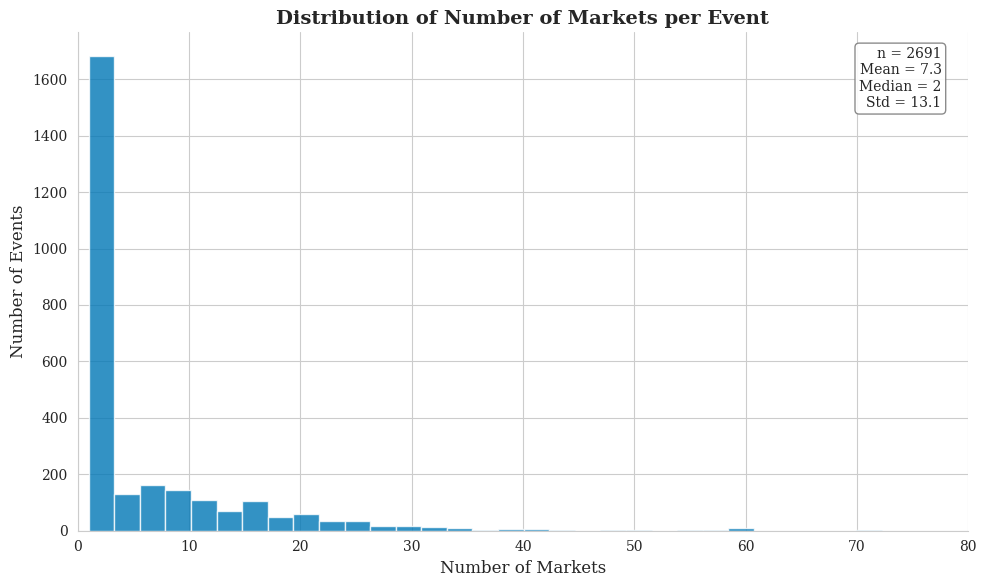

In [24]:
from visualize import plot_num_markets_histogram, plot_num_markets_by_forecaster
plt.rcParams["figure.dpi"] = 300
# check the overall distribution of market numbers
fig,_ = plot_num_markets_histogram(cleaned_df, title="Distribution of Number of Markets per Event", x_lim=(0, 80))

In [25]:
# Define some forecasters of interest
from utils import SELECTED_FORECASTERS, FORECASTER_KEY
# print each forecaster and the number of events they predict on
for forecaster in SELECTED_FORECASTERS:
    pred_df = cleaned_df[cleaned_df[FORECASTER_KEY] == forecaster]
    # get the unique number of event_tickers
    unique_event_tickers = pred_df['event_ticker'].unique()
    print(f"{forecaster}: {len(unique_event_tickers)} events")

anthropic/claude-opus-4.1: 1450 events
x-ai/grok-4: 2609 events
o3: 2455 events
gemini-2.0-flash: 587 events


These forecasters are selected to represent a diverse set -- in the sense that they **DO NOT** all predict on the same set of events. This is made clear by considering their varying [individualized market baseline](https://hackmd.io/@listar2000/BJOM13WS-l) scores.

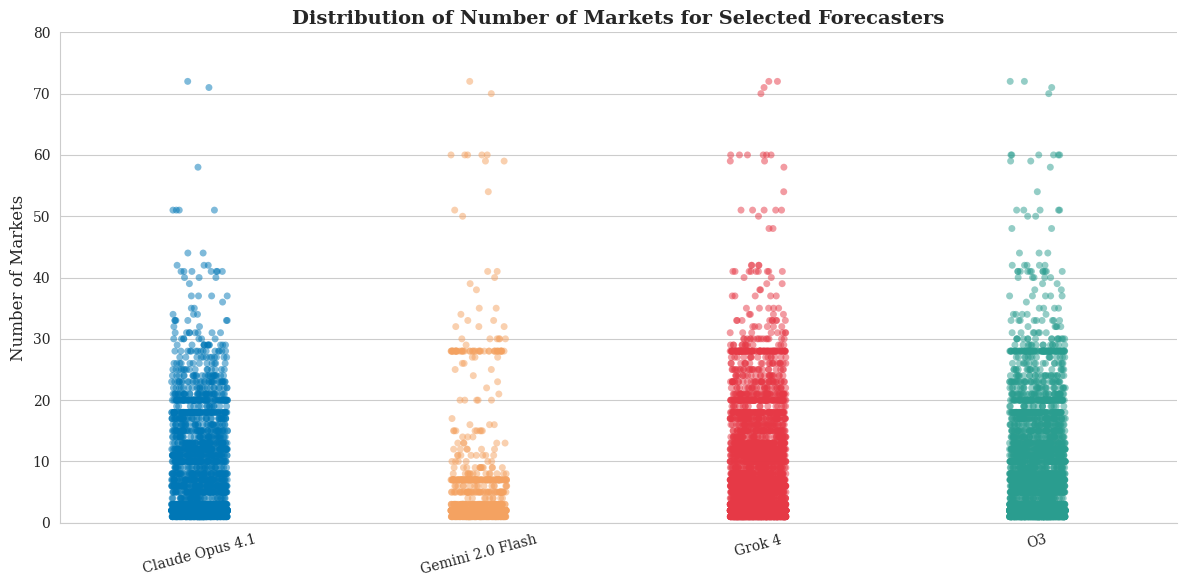

In [26]:
fig, _ = plot_num_markets_by_forecaster(
    cleaned_df, 
    title="Distribution of Number of Markets for Selected Forecasters",
    forecasters=SELECTED_FORECASTERS, 
    plot_type="strip",  # can change this to "box" or "violin"
    y_lim=(0, 80)
)

So we see that: **despite the heterogeneity in the events they predict on, all forecasters show a similar shape in the market number distribution of their predicted events.**

## Part (II): Brier score over the number of markets

Next we investigate how the (averaged) Brier score changes over the number of markets in a prediction event.

> NOTE:
> Below we will turn the option `normalize_by_event` to `True`. This means that we will first average the Brier score over all predictions for a given event, and then take the average over all events.


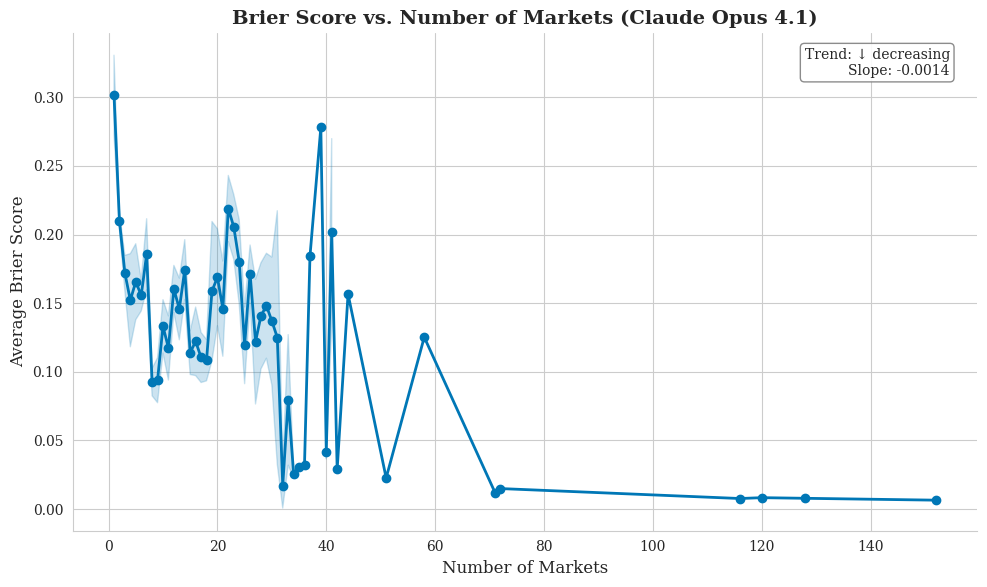

In [27]:
from visualize import plot_brier_vs_num_markets, plot_brier_vs_num_markets_comparison
# plot the Brier score vs. the number of markets for a given forecaster
fig, _ = plot_brier_vs_num_markets(
    cleaned_df, 
    forecaster=SELECTED_FORECASTERS[0],  # can change this to any forecaster in SELECTED_FORECASTERS
    normalize_by_event=True
)

We now zoom in to the (1, 15) range and consider all forecasters of interest. What we see is that the average Brier score decreases quickly initially (<= 5), and then stabilizes. But overall the initial decrease is very sharp (a drop of 0.3 for `Gemini 2.0 Flash`)

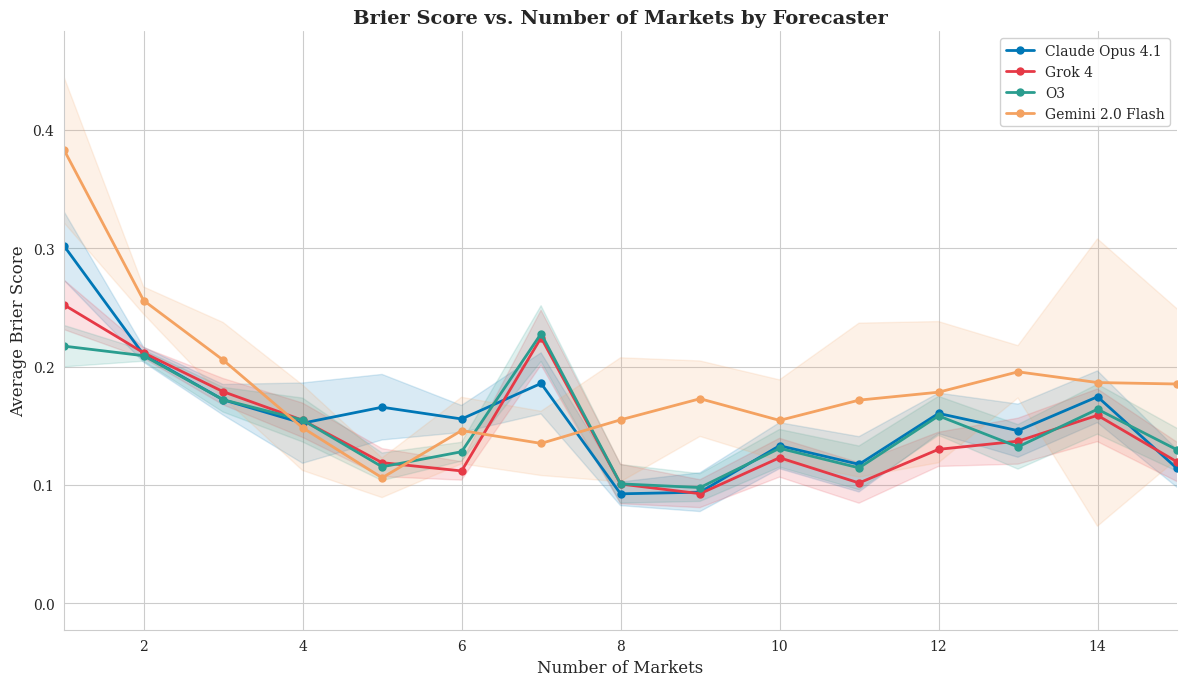

In [28]:
fig, _ = plot_brier_vs_num_markets_comparison(
    cleaned_df, 
    forecasters=SELECTED_FORECASTERS,
    normalize_by_event=True,
    x_lim=(1, 15)
)

## Part (III): Defining a "dilution" metric and how it correlates with the number of markets

From above, we already see the correlation between the Brier score (among a few selected forecasters) and the number of markets in a prediction event. However, what we care more about is not just the number of markets, but a **sparsity metric** that denotes how many "ground-truth" markets (i.e. `market_outcome`) has been realized in the end.

The rationale here is that: suppose a prediction event with many markets has a "sparse" outcome, i.e. only one of its many markets turns out to be True, then even a dummy predictor that **always predicts 0 prob (i.e. False)** for all markets can "suffer less" from the single "mistake". On the other hand, if the outcome is "dense", such behavior will be heavily penalized.

Here we define a very simple "dilution" metric as the ratio of the number of realized markets to the total number of markets in a prediction event. Formally, let an event $E_j$ has $N$ markets with outcomes $o_1, \cdots, o_N$. Then the dilution of $E$ is defined as:

$$
d_j := \text{dilution}(E) = 1 - \frac{1}{N} \sum_{i=1}^N \mathbb{1}(o_i = 1)
$$

> In the visualizatins below we show the $1 - d_j$ version so a higher value means a denser outcome (and smaller dilution effect).

We now first investigate the relationship between the dilution and the number of markets.

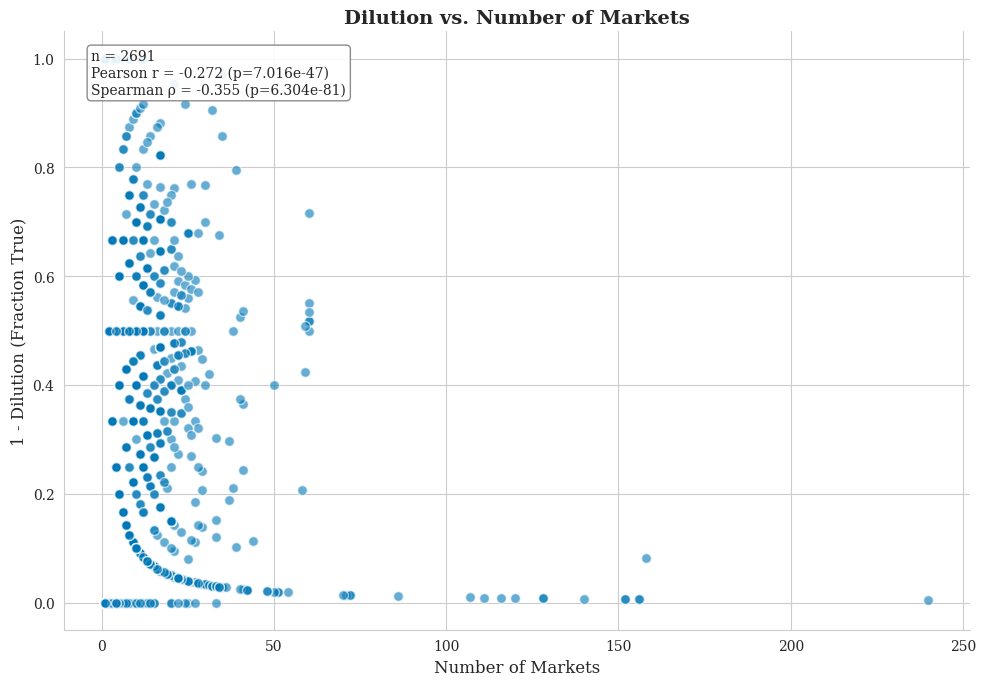

In [29]:
from visualize import plot_dilution_vs_num_markets, plot_dilution_by_market_bins

fig, _ = plot_dilution_vs_num_markets(cleaned_df, show_trend_line=False)

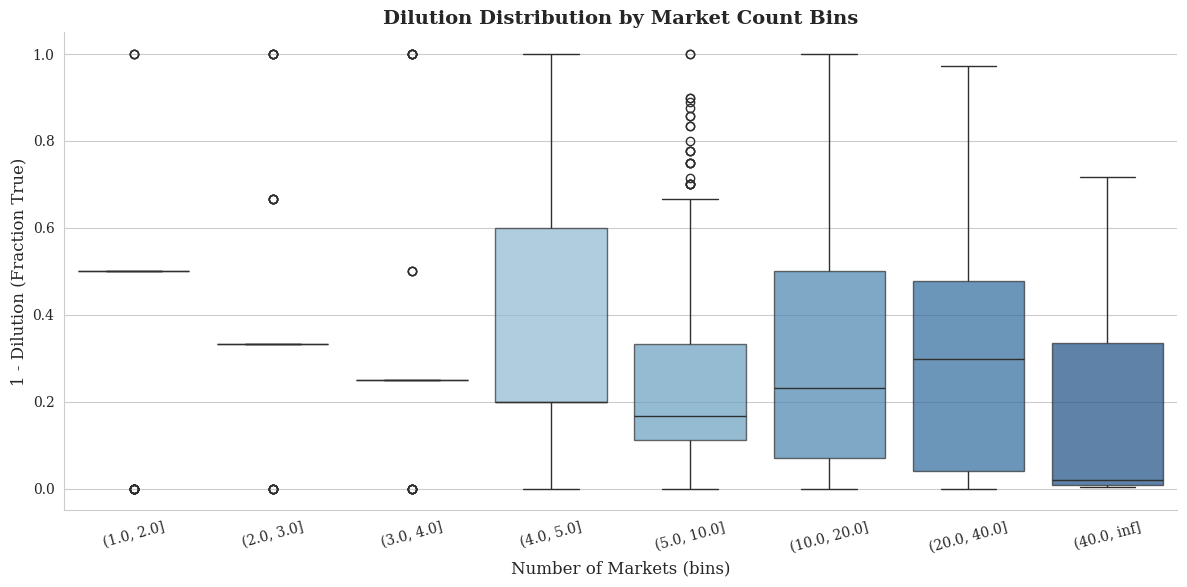

In [30]:
bins = [1, 2, 3, 4, 5, 10, 20, 40]
fig, _ = plot_dilution_by_market_bins(cleaned_df, bins)

The result is not suprising: there's a clear negative correlation between (1 - dilution) and the number of markets. In other words, with the number of markets increases, the outcomes become sparser. This intuitively makes sense as a lot of prediction events with many markets are not "mutually exclusive", while those with a few markets are.

## Part (IV): Brier score and dilution

Finally, we are ready to see how the Brier score relates to the dilution. Our intuition is that Brier score should be negatively correlated with dilution, as a more sparse outcome should "make a prediction easier".

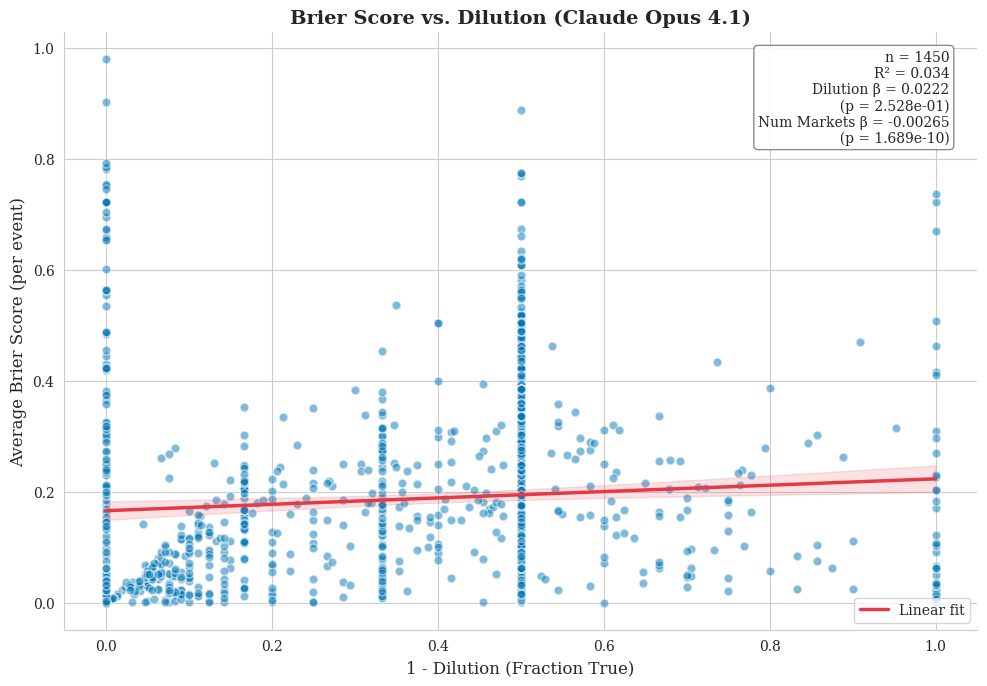

In [ ]:
from visualize import plot_brier_vs_dilution_with_regression, plot_brier_vs_dilution_comparison, plot_regression_coefficients_comparison

fig, _, regression_results = plot_brier_vs_dilution_with_regression(cleaned_df, forecaster=SELECTED_FORECASTERS[0])

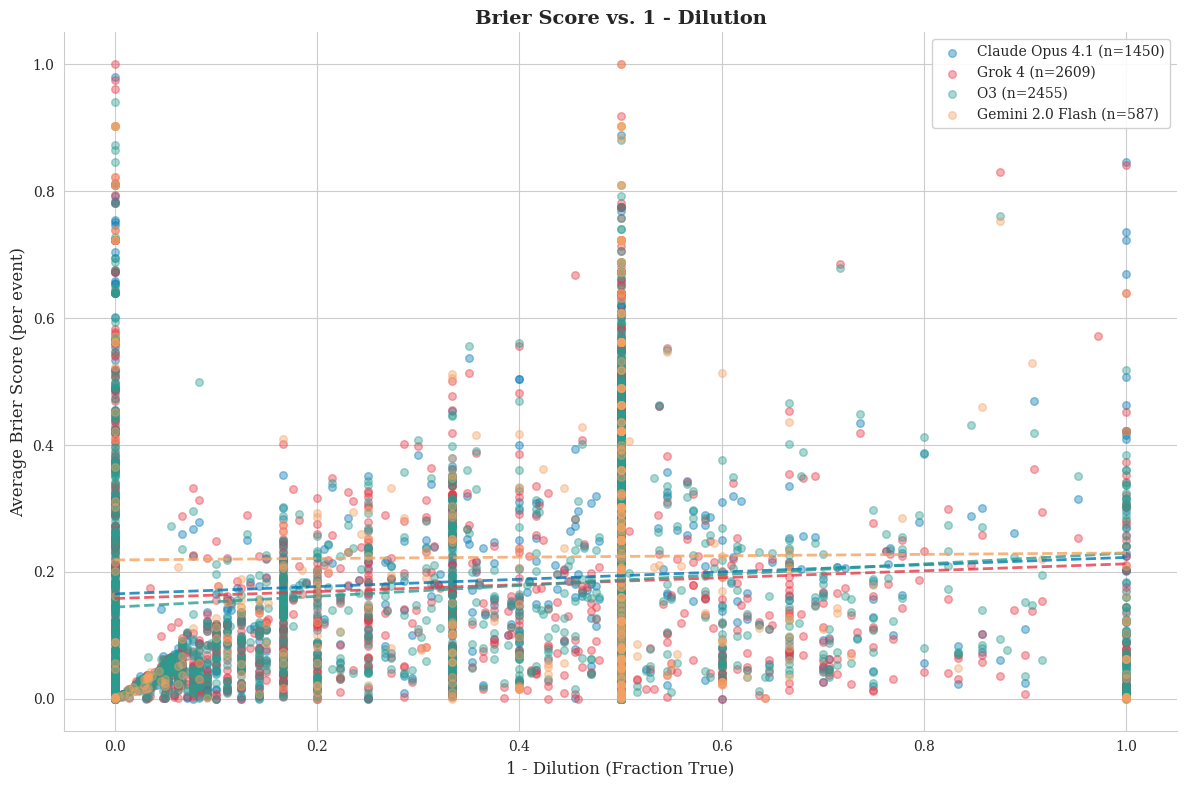

In [35]:
title = "Brier Score vs. 1 - Dilution"
fig, _ = plot_brier_vs_dilution_comparison(cleaned_df, forecasters=SELECTED_FORECASTERS, title=title)

Perhaps a bit surprisingly, there's only very slight positive correlation between Brier score and (1 - dilution), with insufficient $R^2$ to justify a strong trend.

Reflecting on the above, we see that "number of markets" remain a better predictor of Brier score than the (normalized)"dilution" metric.

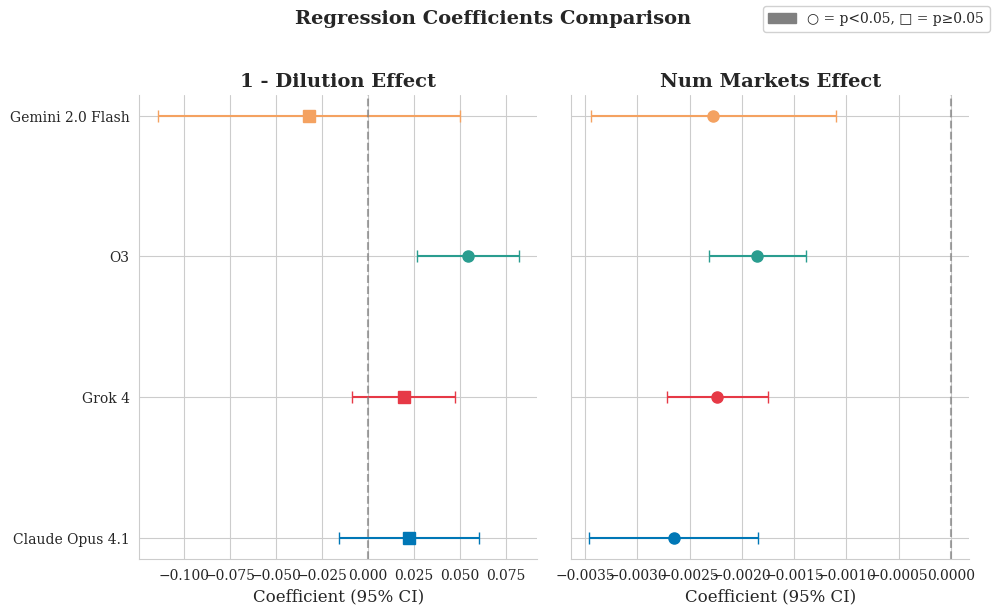

In [36]:
fig, _ = plot_regression_coefficients_comparison(cleaned_df, forecasters=SELECTED_FORECASTERS)

Further note that `O3` and `Grok-4` share a lot of similar events (in their predictions), while both `Gemini` and `O3` are predicting a far smaller set of distinct events. The coefficient plots above also indicate that **the set of events predicted by different forecasters are not homogeneous**.